In [1]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
# os.environ['THEANO_FLAGS']="device=cuda"

import numpy as np
import theano
import pickle

# from numba import njit, prange
from scipy.linalg import svd, qr, inv, pinv
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.linalg import lstsq



import theano.tensor as T
from theano.ifelse import ifelse
from theano.tensor.nlinalg import svd
from theano import function, shared
import arviz as az

from pymc_classes import LogLike



In [2]:
np.__config__.show()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_info']
    libraries = ['openblas_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_info']
    libraries = ['openblas_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_lapack_info']
    libraries = ['openblas_lapack_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    library_dirs = ['C:\\projects\\numpy-wheels\\numpy\\build\\openblas_lapack_info']
    libraries = ['openblas_lapack_info']
    language = f77
    define_macros = [('HAVE_CBLAS', None)]


In [3]:
import pymc3 as pm
# from pymc3.ode import DifferentialEquation


path = r"C:\Users\dominik\Documents\Projects\Bilirubin\UV-Vis data"
# path = r"C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup"


data_led = np.loadtxt(path + r'\LED sources.txt', delimiter='\t', skiprows=1)

LED_355 = data_led[:, 1] / np.trapz(data_led[:, 1])
LED_375 = data_led[:, 2] / np.trapz(data_led[:, 2])
LED_405 = data_led[:, 3] / np.trapz(data_led[:, 3])
LED_420 = data_led[:, 4] / np.trapz(data_led[:, 4])
LED_450 = data_led[:, 5] / np.trapz(data_led[:, 5])
LED_470 = data_led[:, 6] / np.trapz(data_led[:, 6])
LED_490 = data_led[:, 7] / np.trapz(data_led[:, 7])

In [4]:
# pythonic version
def _lstsq_D(C, D):
    U, S, VT = np.linalg.svd(C, full_matrices=False)

    Sr = S[S > S[0] * 1e-10]
    Ur = U[:, :Sr.shape[0]]

    CC_plus_D = Ur.dot(Ur.T).dot(D)

    return CC_plus_D

def Phi(phis, lambda_C=400, wavelengths=None):
    assert isinstance(phis, (list, np.ndarray))
    return sum(par * ((lambda_C - wavelengths) / 100) ** i for i, par in enumerate(phis))

# C, D = T.dmatrix('C'), T.dmatrix('D')

# # theano version
# U, S, VT = svd(C, full_matrices=0, compute_uv=1)

# Sr = S[S > S[0] * 1e-8]
# Ur = U[:, :Sr.shape[0]]
# CC_plus_D = Ur.dot(Ur.T).dot(D)

# _lstsq_D = function([C, D], CC_plus_D)



Text(0, 0.5, 'Absorbance')

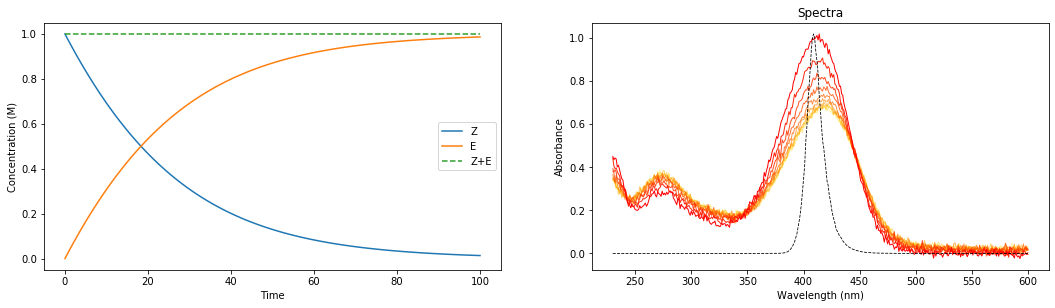

In [5]:
eps = np.loadtxt(r'C:\Users\dominik\Documents\GitHub Repositories\Jupyter-Tutorials\Photoreaction kinetics\fit-A.csv',
                 delimiter=',', skiprows=1)

# eps = np.loadtxt(r'C:\Users\Dominik\Documents\MUNI\Organic Photochemistry\Projects\2019-Bilirubin project\UV-VIS\QY measurement\Photodiode\new setup\spectra_fit.csv',
#                  delimiter=',', skiprows=1)
ST = eps[:, [1, 2]].T  # ST is a matrix of n x w
ST /= ST.max()

wavelengths = eps[:, 0] + 230
N = 100
times = np.linspace(0, 100, N)
# k = 0.05

# C = np.exp(-k * times[:, None])
# D = C @ ST[None, :]

# D = np.random.normal(D, 0.05)


phi = Phi([0.2], 400, wavelengths)
q0, V, c0 = 2e-1, 1, 1
I_source = LED_405

_0 = np.zeros(wavelengths.shape) if isinstance(phi, np.ndarray) else 0

K = np.asarray([[-phi,  _0],
                [+phi,  _0]])

K = np.transpose(K, (2, 0, 1))

const = np.log(10)
eps = ST


def dc_dt_py(c, t):
#     q0 = p[0] 
    c_eps = c[:, None] * eps  # hadamard product
    c_dot_eps = c_eps.sum(axis=0)
    
    q = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2,
                                     (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    product = np.matmul(K, q.T[..., None]).squeeze()  # w x n x 1
    
    return q0 / V * (product.sum(0) - (product[0] + product[-1]) / 2)
    
#     return q0 / V * np.trapz(product, axis=0).squeeze()

# @njit(fastmath=True, parallel=False)
# def dc_dt_numba(c, t):
#     c_eps = c.reshape((-1, 1)) * eps  # hadamard product
#     c_dot_eps = c_eps.sum(0)
    
#     fk_factor = np.zeros_like(c_dot_eps)
#     for i in prange(c_dot_eps.shape[0]):
#         if c_dot_eps[i] < 0.001:
#             fk_factor[i] = const - c_dot_eps[i] * const * const / 2
#         else:
#             fk_factor[i] = (1 - np.exp(-c_dot_eps[i] * const)) / c_dot_eps[i]
            
#     q = c_eps * fk_factor * I_source
    
#     product = np.zeros((c_dot_eps.shape[0], c.shape[0]))
#     for i in prange(c_dot_eps.shape[0]):
#         product[i] = K[i].dot(q[:, i])
        
#     return q0 / V * (product.sum(0) - (product[0] + product[-1]) / 2)
    

def dc_dt(c, t, p):
    q0 = p[0] 

    c_eps = c[:, None] * eps  # hadamard product
    
    c_dot_eps = c_eps.sum(axis=0)
    
#     x_abs = c_eps * T.switch(T.lt(c_dot_eps, 0.001), const - c_dot_eps * const * const / 2, 
#                    (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
    x_abs = c_eps * T.switch(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, 
                   (1 - T.exp(-c_dot_eps * const)) / c_dot_eps) * I_source
    
#     n = x_abs.T[:, :, None]
    
    _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[K, x_abs.T[..., None]])
    
#     product = T.batched_dot(K, x_abs.T[..., None])

    return q0 / V * (_product.sum(axis=0) - (_product[0, ...] + _product[-1, ...]) / 2).squeeze()

#     x_abs = c_eps * np.where(c_dot_eps <= 0.001, const - c_dot_eps * const * const / 2, (1 - np.exp(-c_dot_eps * const)) / c_dot_eps) * I_source

#     # w x n x n   x   w x n x 1
#     product = np.matmul(K, x_abs.T[..., None])  # w x n x 1

#     return q0 / V * np.trapz(_product, axis=0).squeeze()


# t_y = T.vector("y", dtype='float64')
# t_t = T.scalar("t", dtype='float64')
# t_p = T.vector("p", dtype='float64')
# # K = T.tensor3("_K", dtype='float64')


# _func_theano = dc_dt(t_y, t_t, t_p)
# func = function([t_y, t_t, t_p], _func_theano, on_unused_input='warn')

# theano.config.blas.ldflags='-lmkl_rt'


# c = T.tensor3('a', dtype='float64')
# f = T.tensor3('b', dtype='float64')

# _product, _ = theano.scan(lambda a, b: T.dot(a, b), sequences=[c, f])

# _dot_func = function([c, f], _product)

# b = func([1, 0], 0, [1], K)
# b
# np.dot(K[0], b[50]).shape

# _dot_func(K, b).squeeze()

# np.matmul(K, func([1, 0], 0, [1])).squeeze().shape
# K
# K.shape, func([1, 0], 0, [1]).shape

# C = odeint(func, [c0, 0], times, args=((q0,), K))
# C_py = odeint(dc_dt_py, [c0, 0], times, args=((q0,), K))

# np.allclose(C, C_py, rtol=1e-8)

# dc_dt_numba(np.asarray([1, 0]), 0)

C = odeint(dc_dt_py, [c0, 0], times)   #, args=((q0
# %timeit C_numba = odeint(dc_dt_numba, [c0, 0], times)   #, args=((q0,),))

# np.allclose(C, C_numba, rtol=1e-8)


names = ['Z', 'E', 'HL', 'Unknown']

plt.rcParams['figure.figsize'] = [18, 10]
plt.subplot(2, 2, 1)
for i in range(K.shape[2]):
    plt.plot(times, C[:, i], label=names[i])
plt.plot(times, C.sum(axis=1), label='+'.join(names[0:2]), linestyle='--')
plt.xlabel('Time')
plt.ylabel('Concentration (M)')
plt.legend()

D = C @ ST  # compute data matrix
D_obs = np.random.normal(D, 0.01)


# plot time-dependent spectra
t = times.shape[0]
plt.subplot(2, 2, 2)
for i in reversed(range(0, t, 10)):
    plt.plot(wavelengths, D_obs[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=1)
plt.plot(wavelengths, D_obs.max() * I_source / I_source.max(), label='irrsource', linestyle='--', color='black', lw=0.8)
plt.title("Spectra")
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')


In [6]:
ll = LogLike(D, times, wavelengths, ST, I_source, q0, V, [c0, 0])

byt = pickle.dumps(ll)

def _model_func(p):
    return p * p

a = _model_func

pickle.dumps(a)

# np.random.seed(0)
phi, phi1 = np.random.random(20), (np.random.random(50) - 0.5) * 0.2

# phi1 -= 1
# phi1

vals = []

# for i in range(1, 50):
#     vals.append(ll.log_likelihood(np.asarray([0.1, 0.01]), n_MCR_iter=i))


# for p1, p2 in zip(phi, phi1):
#     params = np.asarray([p1, p2])
#     vals.append(ll.log_likelihood(params, n_MCR_iter=2))

    
    
# vals1 = []


# for p1, p2 in zip(phi, phi1):
#     params = np.asarray([p1, p2])
#     vals1.append(ll.log_likelihood(params, n_MCR_iter=2))
    
# vals, vals1 = np.asarray(vals), np.asarray(vals1)
# vals

In [8]:
# np.isclose(vals, vals1, rtol=1e-8, atol=1e-8)

# plt.semilogy(-np.asarray(vals)[2:10])
# plt.show()

In [7]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(wavelengths, ll.calls[0][1].T)
plt.plot(wavelengths, ST.T, color='black', ls='--')
plt.show()

AttributeError: 'LogLike' object has no attribute 'calls'

In [13]:
# create our Op


if __name__ == '__main__':
    
    logl = LogLike(D, times, wavelengths, ST, I_source, q0, V, [c0, 0])

    def _model_func(p):
        return logl(p)

    with pm.Model() as model:

        # Define priors
        phi = pm.Uniform('phi', lower=0, upper=1, testval=0.2)
        phi1 = 0#pm.Normal('phi1', mu=0, sd=1, testval=0)

#         sigma = 0.01 #pm.Normal("sigma", sd=1, testval=0.01)

        params = T.as_tensor_variable([phi, phi1])

        pm.DensityDist('likelihood', _model_func, observed={'p': params})

        trace = pm.sample(1000, tune=20, discard_tuned_samples=True, chains=3, cores=1)
    
#     C = T.exp(-_k * times[:, None])
    
#     U, S, VT = svd(C, full_matrices=0, compute_uv=1)

#     Sr = S[S > S[0] * 1e-8]
#     Ur = U[:, :Sr.shape[0]]
#     CC_plus_D = Ur.dot(Ur.T).dot(D)

    # Define likelihood
#     likelihood = pm.Normal('y', mu=CC_plus_D , sd=sigma, observed=D)

#     # Inference!
#     prior = pm.sample_prior_predictive()
#     trace = pm.sample(5000, tune=1000, cores=6) # draw 3000 posterior samples using NUTS sampling
#     posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (3 chains in 1 job)
Slice: [phi]
Sampling chain 2, 0 divergences: 100%|██████████| 1020/1020 [03:18<00:00,  5.15it/s]


In [11]:
logl.calls.__len__()
# plt.rcParams['figure.figsize'] = [8, 5]
# plt.plot(wavelengths, logl.ST_opts[1400].T)
# plt.plot(wavelengths, ST.T, color='black', ls='--')
# plt.show()
all_phis = np.asarray([logl.calls[i][0] for i in range(len(logl.calls))])

# all_phis
_ = plt.hist(all_phis, bins=100, range=(0.18, 0.22))
            
            

AttributeError: 'LogLike' object has no attribute 'calls'

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


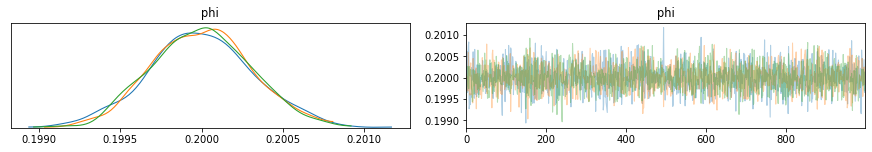

In [14]:

_ = pm.traceplot(trace)

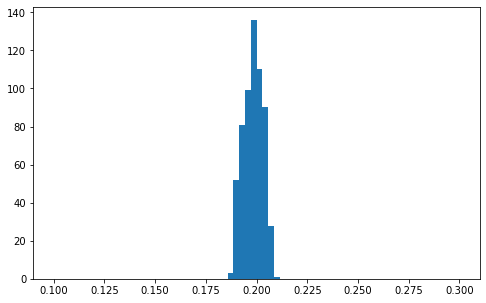

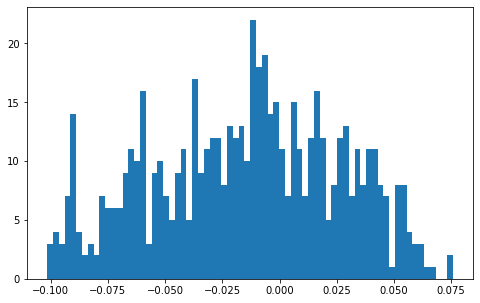

In [30]:
plt.rcParams['figure.figsize'] = [8, 5]
_ = plt.hist(trace['phi'], bins=70, range=(0.1, 0.3))
plt.show()
_ = plt.hist(trace['phi1'], bins=70)

In [139]:
data = az.from_pymc3(trace=trace, prior=prior, posterior_predictive=posterior_predictive)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002350B16DA48>,
      dtype=object)

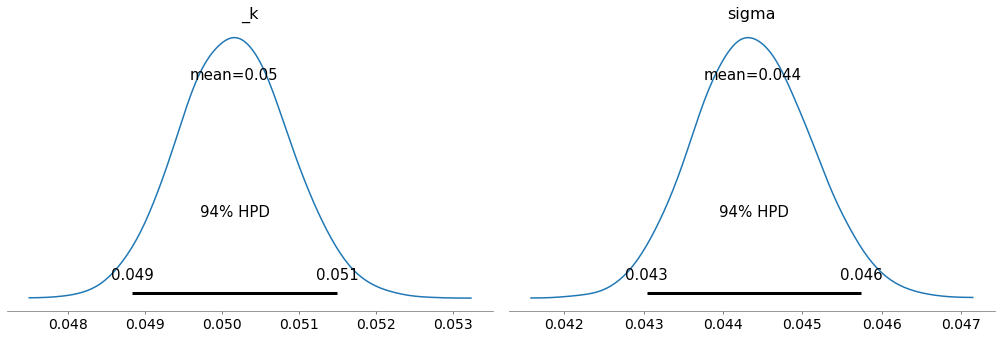

In [140]:
# pm.traceplot(trace[:])
az.plot_posterior(data)

In [126]:
from scipy.linalg import lstsq

trace["_k"].shape
k_samples = trace["_k"]

# k_samples.std()
Cs = np.exp(-k_samples * times[:, None])

STs = np.zeros((k_samples.shape[0], wls.shape[0]))

for i in range(k_samples.shape[0]):
    STs[i] = lstsq(Cs[:, i][:, None], D)[0]

# Cs[:, i].shape, D.shape

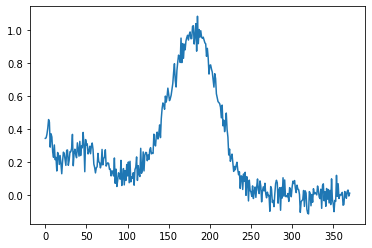

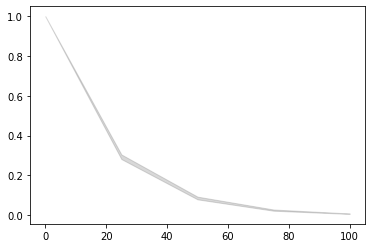

In [131]:
ST_avrg = STs.mean(axis=0)
Cs_avrg = Cs.mean(axis=1)

q_1, q_32, q_68, q_99 = np.quantile(STs, [0.01, 0.32, 0.68, 0.99], axis=0)
q_1, q_32, q_68, q_99 = np.quantile(Cs, [0.01, 0.32, 0.68, 0.99], axis=1)


plt.plot(wls,  ST_avrg)
# plt.fill_between(wls, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()

# plt.plot(times, Cs_avrg.squeeze())
plt.fill_between(times, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

plt.show()


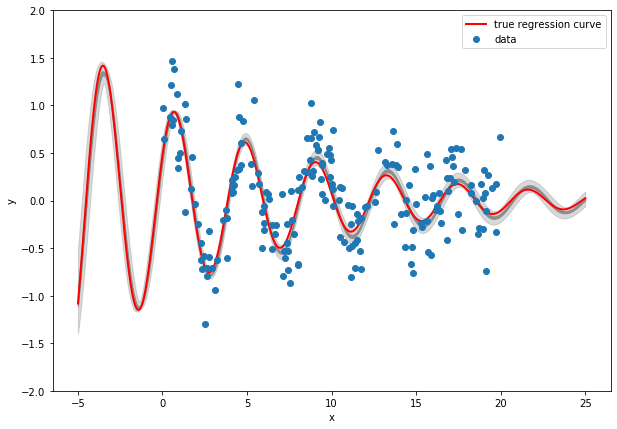

In [7]:
plt.figure(figsize=(10, 7))



# slope_samples = trace[100:]['slope']
# int_samples = trace[100:]['intercept']


# a0_samples = trace[100:]['a0']
# a1_samples = trace[100:]['a1']
# a2_samples = trace[100:]['a2']
# #a3_samples = trace[100:]['a3']


_x = np.linspace(-5, 25, 500)

# curves = a0_samples[:, None] + a1_samples[:, None] * _x[None, :] + a2_samples[:, None] * _x[None, :] ** 2#  + a3_samples[:, None] * _x[None, :] ** 3

curves = _model([a0_samples[:, None], a1_samples[:, None], a2_samples[:, None]], _x[None, :])


# lines = slope_samples[:, None] * _x[None, :] + int_samples[:, None]

# plt.plot(x, lines[::100].T, lw=0.1, color='gray')

true_y = _model(theta, _x)
plt.plot(_x, true_y, label='true regression curve', lw=2., c='r')

q_1, q_32, q_68, q_99 = np.quantile(curves, [0.01, 0.32, 0.68, 0.99], axis=0)


# slope_avrg = slope_samples.mean()
# int_avrg = int_samples.mean()
# line_avrg = slope_avrg  * _x + int_avrg

plt.fill_between(_x, q_32, q_68, color=(0.5, 0.5, 0.5, 0.8))
plt.fill_between(_x, q_1, q_99, color=(0.5, 0.5, 0.5, 0.3))

# plt.fill_between(_x, true_y + 2 * stds, true_y - 2 * stds, color=(0.5, 0.5, 0.5, 0.5))
# plt.fill_between(_x, true_y + 3 * stds, true_y - 3 * stds, color=(0.5, 0.5, 0.5, 0.3))

# plt.plot(_x, _model([a0_samples.mean(), a1_samples.mean(), a2_samples.mean()], _x), label='fit', lw=2., c='b')

plt.plot(x, y, 'o', label='data')



# plt.title('Posterior predictive regression lines')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2, 2)


plt.show()


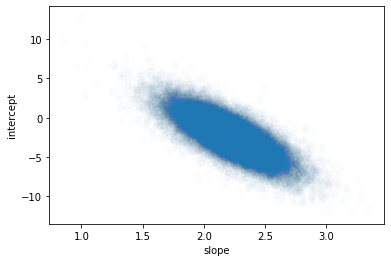

In [9]:
plt.plot(slope_samples[::1], int_samples[::1], 'o', alpha=0.01)
plt.xlabel('slope')
plt.ylabel('intercept')
plt.show()

In [86]:
samples = poisson_param.random(size=500000)

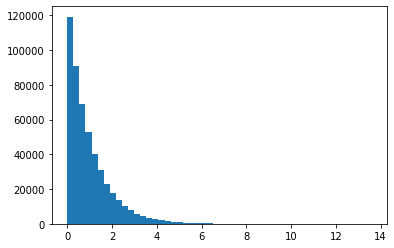

In [90]:
res = plt.hist(samples, bins=50, histtype="stepfilled")

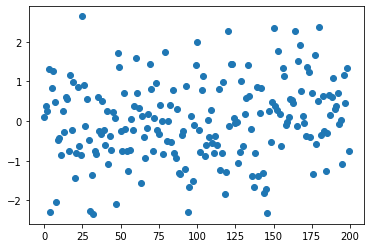

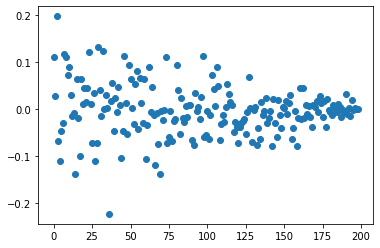

In [37]:
x = np.random.normal(0, 1, size=200)

corr =np.correlate(x, x, mode='full')
corr /= corr.max()
corr = corr[corr.size // 2 + 1:]

plt.plot(x, 'o')
plt.show()
plt.plot(corr, 'o')